# Semi-empirical rudder rudder model compared to SLIC model

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
#%config Completer.use_jedi = False

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.extended_kalman_vmm import ExtendedKalman, SystemMatrixes
from vmm_abkowitz_diminished import vmm as vmm
from wPCC_pipeline.pipelines.brix.nodes import initial_parameters, extract_added_masses
from wPCC_pipeline.pipelines.preprocess.nodes import load, add_thrust
from wPCC_pipeline.pipelines.filter_data_extended_kalman.nodes import guess_covariance_matrixes, initial_state, extended_kalman_filter, extended_kalman_smoother
from wPCC_pipeline.pipelines.motion_regression.nodes import predict_force, fit_motions, create_model_from_motion_regression
from wPCC_pipeline.pipelines.prediction.nodes import simulate_euler
from phd.pipelines.load_7m.nodes import fix_interpolated_angle
from sklearn.metrics import mean_squared_error
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator, get_coefficients
import sympy as sp
from functools import reduce
from operator import add
from vessel_manoeuvring_models.symbols import *
import vessel_manoeuvring_models.symbols as symbols
from vessel_manoeuvring_models.models.propeller import *
from vessel_manoeuvring_models.models.semiempirical_rudder import *
from IPython.display import display
from vessel_manoeuvring_models.prime_system import df_prime
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator
from vessel_manoeuvring_models.parameters import df_parameters
from phd.helpers import mean
from vessel_manoeuvring_models.angles import mean_angle
from vessel_manoeuvring_models.angles import smallest_signed_angle
from vessel_manoeuvring_models.models.diff_eq_to_matrix import DiffEqToMatrix
import inspect

import logging
log = logging.getLogger(__name__)

import matplotlib.pyplot as plt
plt.style.use('bmh')

In [3]:
%reload_kedro
ship='wPCC'
time_series = catalog.load(f"{ship}.time_series")
time_series_smooth = catalog.load(f"{ship}.time_series_preprocessed.ek_smooth")
ship_data = catalog.load(f"{ship}.ship_data")
exclude_parameters = catalog.load(f"params:{ship}.exclude_parameters")
time_series_meta_data = catalog.load(f"{ship}.time_series_meta_data")
time_series_meta_data.index = time_series_meta_data.index.astype(str)
time_series_meta_data.rename(columns={'test_type':'test type'}, inplace=True)
model_loader = catalog.load(f"{ship}.models")

[06/07/23 09:40:24] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=201447;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=101216;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[06/07/23 09:40:32] INFO     Kedro project phd                                                      ]8;id=47649;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=334124;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=669143;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=996621;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=718355;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=656741;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#110\110]8;;\

                    INFO     Loading data from 'wPCC.time_series' (PartitionedDataSet)...       ]8;id=931180;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=750889;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'wPCC.time_series_preprocessed.ek_smooth'        ]8;id=151028;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=569884;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (PartitionedDataSet)...                                                               

                    INFO     Loading data from 'wPCC.ship_data' (YAMLDataSet)...                ]8;id=380702;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=983716;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'params:wPCC.exclude_parameters'                 ]8;id=263214;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=276609;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (MemoryDataSet)...                                                                    

                    INFO     Loading data from 'wPCC.time_series_meta_data' (CSVDataSet)...     ]8;id=508036;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=931687;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'wPCC.models' (PartitionedDataSet)...            ]8;id=581096;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=350437;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [4]:
model_loader.keys()

dict_keys(['SLIC_propeller', 'modular', 'semiempirical_rudder', 'vmm_abkowitz_diminished', 'wpcc.updated.vmm_martins_simple.joined.model'])

In [5]:
model = model_loader['SLIC_propeller']()

In [6]:
data = time_series_smooth['wpcc.updated.22773.ek_smooth']()
#data = time_series_smooth['wpcc.updated.22774.ek_smooth']()
data['V'] = data['U'] = np.sqrt(data['u']**2 + data['v']**2)
data['rev'] = data[['Prop/SB/Rpm', 'Prop/PS/Rpm']].mean(axis=1)
g_=9.81
data['g'] = g_

In [7]:
result = model.simulate(data)

<Axes: title={'center': 'Track plot'}, xlabel='$y_0$ $[m]$', ylabel='$x_0$ $[m]$'>

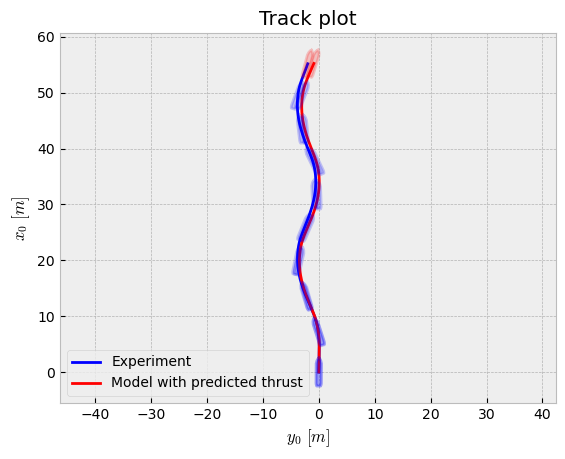

In [8]:
result_with_measured_thrust = model.simulate(data)

dataframes = {'Experiment':data,
              'Model with predicted thrust':result.result,
             }
track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], N=10)

In [9]:
model.Y_qs_lambda

<function _lambdifygenerated(Ydelta, Yr, Ythrust, Ythrustdelta, Yu, Yur, Yv, Yvvdelta, delta, r, thrust, u, v)>

In [10]:
rudder_particulars = {
'x_R' : ship_data['x_r'],
'y_R' : 0,
'z_R' : 0,
'A_R' : 70/(ship_data['scale_factor']**2),
'b_R'  : 7.18/ship_data['scale_factor'],
'n_prop':ship_data['n_prop'],
'w_f':ship_data['w_p0'],
}

prop_data = {
'r_0': ship_data['D']/2,
'x': 0.10,  # Guessing...
}


In [11]:
rudder_parameters = {
"C_L_tune" : 1.0,
"delta_lim": np.deg2rad(40),
"kappa": 0.5, # (Small value means much flow straightening)
"rho":1000,
}

In [12]:
lambdas_propeller

{V_x: <function _lambdifygenerated(T, r_0, rho, u, w_f, x)>,
 r_inf: <function _lambdifygenerated(V_A, V_inf, r_0)>,
 r_p: <function _lambdifygenerated(V_A, V_inf, r_0, x)>,
 V_xcorr: <function _lambdifygenerated(T, V_x, r_0, rho, u, w_f, x)>}

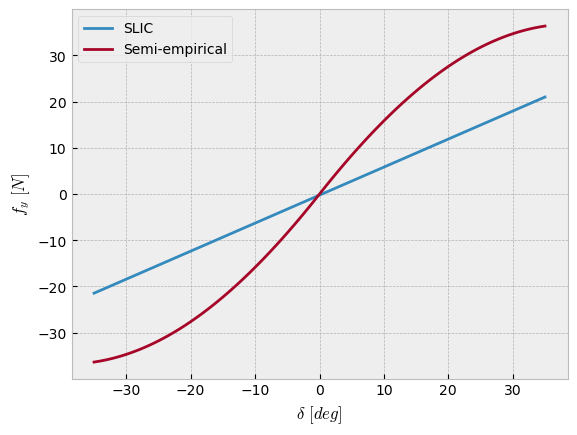

In [16]:
df = pd.DataFrame()
df['delta'] = np.deg2rad(np.linspace(-35,35,100))
df['V'] = data['V'].mean()
df['u'] = df['V']
df['v'] = 0
df['r'] = 0
df['thrust'] = data['thrust'].mean()
df_prime = model.prime_system.prime(df, U=df['V'])

df_prime['fy'] = run(function = model.Y_qs_lambda, inputs=df_prime, **model.parameters)
df_result = model.prime_system.unprime(df_prime, U=df['V'])

df['T'] = df['thrust']/ship_data['n_prop']
prediction = df.copy()
prediction['V_x'] = run(function=lambdas_propeller[V_x], inputs=df, **rudder_particulars, **rudder_parameters, **prop_data)
## Apply correction
#prediction['V_x'] = run(function=lambdas_propeller[V_xcorr], inputs=prediction, **rudder_particulars, **rudder_parameters, **prop_data)
prediction['fy_rudders'] = run(function=lambdas_lift[Y_R], inputs=prediction, **rudder_particulars, **rudder_parameters)

fig,ax=plt.subplots()
ax.plot(np.rad2deg(df_result['delta']), df_result['fy'], label='SLIC')
ax.plot(np.rad2deg(prediction['delta']), prediction['fy_rudders'], label='Semi-empirical')
ax.legend()
ax.set_xlabel(r'$\delta$ $[deg]$')
ax.set_ylabel(r'$f_y$ $[N]$')
fig.savefig("summaries/SLIC_vs_semiempirical_rudder.png")

Text(0, 0.5, '$f_y$ $[N]$')

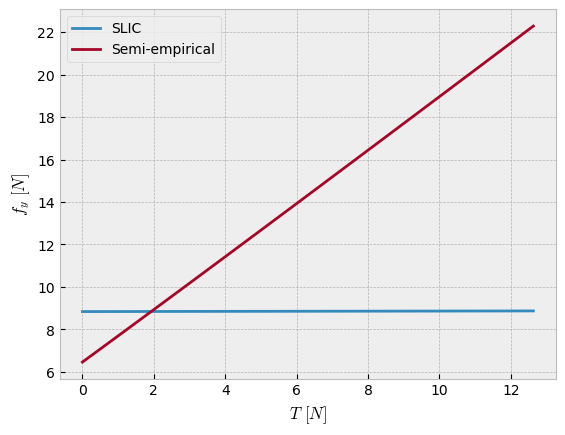

In [14]:
df = pd.DataFrame()
df['thrust'] = np.linspace(0,data['thrust'].mean(),100)
df['delta'] = np.deg2rad(15)
df['V'] = data['V'].mean()
df['u'] = df['V']
df['v'] = 0
df['r'] = 0

df_prime = model.prime_system.prime(df, U=df['V'])

df_prime['fy'] = run(function = model.Y_qs_lambda, inputs=df_prime, **model.parameters)
df_result = model.prime_system.unprime(df_prime, U=df['V'])

df['T'] = df['thrust']/ship_data['n_prop']
prediction = df.copy()
prediction['V_x'] = run(function=lambdas_propeller[V_x], inputs=df, **rudder_particulars, **rudder_parameters, **prop_data)
## Apply correction
#prediction['V_x'] = run(function=lambdas_propeller[V_xcorr], inputs=prediction, **rudder_particulars, **rudder_parameters, **prop_data)
prediction['fy_rudders'] = run(function=lambdas_lift[Y_R], inputs=prediction, **rudder_particulars, **rudder_parameters)

fig,ax=plt.subplots()
ax.plot(df_result['thrust'], df_result['fy'], label='SLIC')
ax.plot(prediction['thrust'], prediction['fy_rudders'], label='Semi-empirical')
ax.legend()
ax.set_xlabel(r'$T$ $[N]$')
ax.set_ylabel(r'$f_y$ $[N]$')